In [23]:
import numpy as np
import scipy.integrate as integrate
from numpy.linalg import inv
import math as m
from functions import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import importlib
from fpdf import FPDF

%load_ext autoreload

%autoreload 2

np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This next block will create a class for all of our inputs to be placed into. This will allow for all inputs to have easily accessed names, values, and units.

In [24]:
class Input:
    def __init__(self, name, value, unit):
        self.name = name
        self.value = value
        #self.valueType = type(value)
        self.unit = unit
    
    def print_values(self):
        print("\n")
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")

# Please fill in all inputs and their units below
# v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v 

# Constants
<br>For Reference: Units Set: Pa, N, m4, m

In [25]:
YOUNGSMODULUS = 200 * (10**9)
YM_UNIT = "Pa"

MOI = 4 * (10**(-4))
MOI_UNIT = "m4"

W3 = 0 
#dist_load_length = 108 #length that the distributed load acts upon in the corresponding units to W3
#load_direction = -1 #negative 1 if distributed load points down, +1 otherwise
FORCE_UNIT = "N"

nArray = np.array([[1,2], [2,3]])
print(f"number of elements: {len(nArray)}")

coords = np.array([[0,0], [3,0], [6,0]])
print(coords)

LENGTHS_UNIT = "m"

problem_number = 2

homework_number = 6




number of elements: 2
[[0 0]
 [3 0]
 [6 0]]


# Boundary Conditions
#### for v & phi: [node#, v, phi] -> v and phi are assumed to be unknown (None) -> only input if known
#### for forces: [node#, Fy, moment] -> forces and moments are assumed to be 0 -> only input if not 0

<br>Please note, node# are inputted straight from the diagram - do not adjust for python counting

In [26]:
v_phi_bcs = np.array([[1, 0, 0],[3, 0, 0]])

forceMoment_BCs = np.array([[2, -20000, 20000]])

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Create our final output pdf

In [27]:
filename = f'HW{homework_number} Problem {problem_number} Numerical Outputs.txt'
f = open(filename, 'w')

f = open(filename, 'a')
f.write(f"Numerical Outputs for HW{str(homework_number)} Problem {str(problem_number)}\n\n")

37

In [28]:
E = Input("Young's Modulus", YOUNGSMODULUS, YM_UNIT)
E.print_values()

I_ = Input("Moment of Inertia", MOI, MOI_UNIT)
I_.print_values()

nodes = Input("Node numbers", nArray, "None")
nodes.print_values()

nodeCoordinates = Input("Node Coordinates (x, y)", coords, LENGTHS_UNIT)
nodeCoordinates.print_values()

total_length = np.max(nodeCoordinates.value)
print(f"total length: {total_length}")





name: Young's Modulus
value: 200000000000
unit: Pa


name: Moment of Inertia
value: 0.0004
unit: m4


name: Node numbers
value: [[1 2]
 [2 3]]
unit: None


name: Node Coordinates (x, y)
value: [[0 0]
 [3 0]
 [6 0]]
unit: m
total length: 6


number of elements is the number of rows in nodes
<br>number of nodes is the maximum number found in nodes

In [29]:
count_elems = len(nodes.value)
print(f"number of elements: {count_elems}")

count_nodes = nodes.value.max()
print(f"number of nodes: {count_nodes}")

dimension = (2*count_nodes)
print(f"dimension = {dimension}")

number of elements: 2
number of nodes: 3
dimension = 6


In [30]:
LENGTHS = np.zeros(count_elems)
print(LENGTHS)

for i in range(count_elems):

    connection = nodes.value[i]
    N1 = connection[0]
    N2 = connection[1]

    x1 = (nodeCoordinates.value[N1-1])[0]
    y1 = (nodeCoordinates.value[N1-1])[1]

    x2 = (nodeCoordinates.value[N2-1])[0]
    y2 = (nodeCoordinates.value[N2-1])[1]

    LENGTHS[i] = get_element_length(x1, y1, x2, y2)

    print(f"element {i+1}: length = {LENGTHS[i]} (raw value)")

print(LENGTHS)

lengths = Input("Lengths", LENGTHS, LENGTHS_UNIT)
lengths.print_values()


[0. 0.]
element 1: length = 3.0 (raw value)
element 2: length = 3.0 (raw value)
[3. 3.]


name: Lengths
value: [3. 3.]
unit: m


two reactions per node
<br>v_phi_list -> list of unknowns (node displacements)
<br>we can input our known values -> fixed_nodes at nodes 4 & 5
<br>these fixed nodes numbers are taken straight from diagram (not adjusted for python counting)
<br><br>u and v for any given node is given as (node# - 1)* 2 and ((node# -1)* 2) + 1 respectively.


In [31]:
v_phi_list = [None]*(dimension)
print("displacement bcs: [node number, y disp (v), angle of rotation (phi)]")
print(v_phi_bcs)

adjust_array(v_phi_list, v_phi_bcs, "displacements")

print("v & phi list:")
print(v_phi_list)

displacement bcs: [node number, y disp (v), angle of rotation (phi)]
[[1 0 0]
 [3 0 0]]
adjusting array to account for: displacements boundary conditions
case 1 for BC 1
Case 2 for BC 1
case 1 for BC 2
Case 2 for BC 2
done adjusting displacements array!
v & phi list:
[0, 0, None, None, 0, 0]


Same procedure as displacement BCs for forces
<br>Input BCs given as : [node #, x force, y force]

In [32]:
force_list = [0]*dimension
#force_list = np.zeros(((count_nodes*2), 1))

nodesWithLoads = []

loadedNodes = 0

for i in range(len(forceMoment_BCs)):
    if forceMoment_BCs[i,1] != None or forceMoment_BCs[i,2] != None:
        loadedNodes += 1
        nodesWithLoads.append((forceMoment_BCs[i,0] - 1))

for i in range(len(v_phi_list)):
    if v_phi_list[i] == 0:
        force_list[i] = None
    elif v_phi_list[i] is None:
        force_list[i] = 0

#adjust force array given concentrated loading conditions
adjust_array(force_list, forceMoment_BCs, "forces")

print(f"number of nodes with concentrated loads: {loadedNodes}")
print(f"at nodes: {nodesWithLoads}")

print(f"force list: \n{force_list}")

adjusting array to account for: forces boundary conditions
case 1 for BC 1
Case 2 for BC 1
done adjusting forces array!
number of nodes with concentrated loads: 1
at nodes: [1]
force list: 
[None, None, -20000, 20000, None, None]


In [33]:
print(create_NT(1, 3)[0,3])

-0.2222222222222222


In [34]:
if W3 != 0:
    m_constant = W3/dist_load_length
    print(f"slope = {m_constant}")
    loose_ft = [0] * (count_elems * 4)

    fw = [0] * dimension
    #for each element, create local fw and transport to global
    for i in range(count_elems):
        b_constant = 0 if i == 0 else lengths.value[i-1] * m_constant
        print(f"for element {i+1}: b constant: {b_constant}")

        """
        (x)*m + b) -> surface traction function
        x+ i*lengths.value[i] adjusts local element x axis to global x
        [N]T from create_NT
        """
        tStar1 = lambda x: (create_NT(x, lengths.value[i]))[0,0] * load_direction * (m_constant*(x) + b_constant)
        tStar2 = lambda x: (create_NT(x, lengths.value[i]))[0,1] * load_direction * (m_constant*(x) + b_constant)
        tStar3 = lambda x: (create_NT(x, lengths.value[i]))[0,2] * load_direction * (m_constant*(x) + b_constant)
        tStar4 = lambda x: (create_NT(x, lengths.value[i]))[0,3] * load_direction * (m_constant*(x) + b_constant)  

        ft1, error = integrate.quad(tStar1, 0, lengths.value[i])
        ft2, error = integrate.quad(tStar2, 0, lengths.value[i])
        ft3, error = integrate.quad(tStar3, 0, lengths.value[i])
        ft4, error = integrate.quad(tStar4, 0, lengths.value[i]) 

        fw[2*i] += ft1
        fw[(2*i) + 1] += ft2
        fw[(2*i) + 2] += ft3
        fw[(2*i) + 3] += ft4

        loose_ft[(4*i)] = ft1
        loose_ft[(4*i) + 1] = ft2
        loose_ft[(4*i) + 2] = ft3
        loose_ft[(4*i) + 3] = ft4

        print(f"ft1 = {ft1}, ft2 = {ft2}, ft3 = {ft3}, ft4 = {ft4}")
    print(f"loose ft = {loose_ft}, length = {len(loose_ft)}")
else: 
    fw = 0

print(f"fw = {fw}")


fw = 0


Global [k] matrix is a symmetric array of shape (count_nodes x 2, count_nodes x 2)
<br>beam constants are one per element, stored in a numElemes * 1 array.

In [35]:
global_K = np.zeros((dimension, dimension))
print(f"Global K array dimensions: {global_K.shape}")

beam_constant = np.zeros((count_elems,1))
for i in range(count_elems):
    print(f"E = {E.value}, I = {I_.value}, length for element {i+1} = {lengths.value[i]}")
    beam_constant[i] = (E.value*I_.value)/(lengths.value[i]**3)

print(f"beam constants = \n{beam_constant}")

Global K array dimensions: (6, 6)
E = 200000000000, I = 0.0004, length for element 1 = 3.0
E = 200000000000, I = 0.0004, length for element 2 = 3.0
beam constants = 
[[2962962.96296296]
 [2962962.96296296]]


## Creating the finite element equation for each Truss Element
### Combining into the global K array

In [36]:
for i in range(count_elems):
    local_K = create_beam_local_k(lengths.value[i])
    local_K *= beam_constant[i]
    print(f"\nk matrix for element {i+1}: \n{local_K}")
    #print(local_K)
    start_node = nodes.value[i,0]
    end_node = nodes.value[i,1]
    print(f"Element {i+1} starting at node: {start_node} and ending at node: {end_node}")
    #print(np.vsplit(local_K, 2))
    Sn = (start_node - 1)*2
    En = (end_node - 1)*2
    #first, adjust 0,0 -> then, 2,0; 0,2; and 2,2
    block_array_adjust(Sn, Sn, global_K, 0, 0, local_K)
    block_array_adjust(En, Sn, global_K, 2, 0, local_K)
    block_array_adjust(Sn, En, global_K, 0, 2, local_K)
    block_array_adjust(En, En, global_K, 2, 2, local_K)

print(f"\nGlobal K matrix: \n{global_K}")
unmodified_global_K = global_K.copy()
check_symmetric(global_K)


k matrix for element 1: 
[[ 3.55555556e+07  5.33333333e+07 -3.55555556e+07  5.33333333e+07]
 [ 5.33333333e+07  1.06666667e+08 -5.33333333e+07  5.33333333e+07]
 [-3.55555556e+07 -5.33333333e+07  3.55555556e+07 -5.33333333e+07]
 [ 5.33333333e+07  5.33333333e+07 -5.33333333e+07  1.06666667e+08]]
Element 1 starting at node: 1 and ending at node: 2

k matrix for element 2: 
[[ 3.55555556e+07  5.33333333e+07 -3.55555556e+07  5.33333333e+07]
 [ 5.33333333e+07  1.06666667e+08 -5.33333333e+07  5.33333333e+07]
 [-3.55555556e+07 -5.33333333e+07  3.55555556e+07 -5.33333333e+07]
 [ 5.33333333e+07  5.33333333e+07 -5.33333333e+07  1.06666667e+08]]
Element 2 starting at node: 2 and ending at node: 3

Global K matrix: 
[[ 3.55555556e+07  5.33333333e+07 -3.55555556e+07  5.33333333e+07
   0.00000000e+00  0.00000000e+00]
 [ 5.33333333e+07  1.06666667e+08 -5.33333333e+07  5.33333333e+07
   0.00000000e+00  0.00000000e+00]
 [-3.55555556e+07 -5.33333333e+07  7.11111111e+07  0.00000000e+00
  -3.55555556e+07  

In [37]:
if W3 != 0:  
    force_list = fw
print(force_list)

[None, None, -20000, 20000, None, None]


In [38]:
j = 0
while j < count_nodes*2:
    print(f"{j}")
    #if j in nodesWithLoads:
     #   j+=2
    #first case: displacement BC = 0. In this case, set combined force values to 0, and alter 
    #global_K to reflect the changes.
    if v_phi_list[j] == 0:
        print(f"u = 0 at row: {j}")
        force_list[j] = 0 
        global_K[j] = 0
        global_K[j,j] = 1
        j+=1
    elif v_phi_list[j] is None:
        print(f"none detected at row {j}")
        j+=1
    else: #when we have a known, non-zero displacement boundary condition
        #alter global stiffness to all zeros and one 1, and set force equal to displacement BC
        print(f"row {j} altered")
        print(v_phi_list[j])
        force_list[j] = v_phi_list[j]
        for c in range(count_nodes):
            if (global_K[j,c] > 0) == True:
                global_K[j,c] = 1
            else:
                global_K[j,c] = 0
        j+=1

                
print(global_K)
print(f"modified forces: {force_list}")
#complete_forces = np.add(np.array(force_list), np.array(fw))
#print(complete_forces)

0
u = 0 at row: 0
1
u = 0 at row: 1
2
none detected at row 2
3
none detected at row 3
4
u = 0 at row: 4
5
u = 0 at row: 5
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.55555556e+07 -5.33333333e+07  7.11111111e+07  0.00000000e+00
  -3.55555556e+07  5.33333333e+07]
 [ 5.33333333e+07  5.33333333e+07  0.00000000e+00  2.13333333e+08
  -5.33333333e+07  5.33333333e+07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
modified forces: [0, 0, -20000, 20000, 0, 0]


In [39]:
#global_K.round(0)
global_K_inv = inv(global_K)
print(global_K_inv)

node = 1

final_u_phi = np.matmul(global_K_inv, force_list)

for i in range(len(final_u_phi)):
    if check_even(i) == True:
        print(f"u{node} = {final_u_phi[i]} {LENGTHS_UNIT}")
        f.write(f"u{str(node)} = {str(round(final_u_phi[i], 7))} {str(LENGTHS_UNIT)}\n")
    else:
        print(f"phi{node} = {final_u_phi[i]} rad\n")
        f.write(f"phi{str(node)} = {str(round(final_u_phi[i], 7))} rad\n")
        node += 1 

[[ 1.         -0.          0.         -0.          0.          0.        ]
 [-0.          1.         -0.         -0.         -0.         -0.        ]
 [ 0.5         0.75        0.00000001 -0.          0.5        -0.75      ]
 [-0.25       -0.25       -0.          0.          0.25       -0.25      ]
 [ 0.          0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]]
u1 = -5.487861706949054e-20 m
phi1 = -1.1788672143499262e-20 rad

u2 = -0.00028125000000000003 m
phi2 = 9.375000000000002e-05 rad

u3 = 0.0 m
phi3 = 0.0 rad



### Finding forces

In [40]:
elem_forces_moments = [0] * (count_elems*4)
for i in range(count_elems):
    mover = 4*i
    if W3 != 0:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]
        local_U = np.array([
            [final_u_phi[2*i]],
            [final_u_phi[(2*i) + 1]], 
            [final_u_phi[(2*i) + 2]], 
            [final_u_phi[(2*i) + 3]]
        ])
        local_fw = np.array([
            [loose_ft[mover]], 
            [loose_ft[mover + 1]], 
            [loose_ft[mover + 2]], 
            [loose_ft[mover + 3]]
        ])
        local_forces = np.subtract((local_K @ local_U), local_fw)

        #negatives convert to EB sign convention
        #local_forces[1,0] *= -1
        #local_forces[2,0] *= -1

        elem_forces_moments[mover] = local_forces[0,0]
        elem_forces_moments[mover + 1] = local_forces[1,0]
        elem_forces_moments[mover + 2] = local_forces[2,0]
        elem_forces_moments[mover + 3] = local_forces[3,0]

        print(f"local forces (element {i+1}) [{FORCE_UNIT}] = \n{local_forces}")
    else:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]
        local_U = np.array([
            [final_u_phi[2*i]],
            [final_u_phi[(2*i) + 1]], 
            [final_u_phi[(2*i) + 2]], 
            [final_u_phi[(2*i) + 3]]
        ])
        local_forces = local_K @ local_U

        

        elem_forces_moments[mover] = local_forces[0,0]
        elem_forces_moments[mover + 1] = local_forces[1,0]
        elem_forces_moments[mover + 2] = local_forces[2,0]
        elem_forces_moments[mover + 3] = local_forces[3,0]

        print(f"local forces (element {i+1}) [{FORCE_UNIT}] = \n{local_forces}")


print(f"collected element forces [{FORCE_UNIT}] = \n{elem_forces_moments}")
rounded_f_m = [round(element , 4) for element in elem_forces_moments]
f.write(f"\nForces, Moments = \n{rounded_f_m}\n{FORCE_UNIT}, {FORCE_UNIT}*{LENGTHS_UNIT}")


local forces (element 1) [N] = 
[[ 15000.]
 [ 20000.]
 [-15000.]
 [ 25000.]]
local forces (element 2) [N] = 
[[ -5000.]
 [ -5000.]
 [  5000.]
 [-10000.]]
collected element forces [N] = 
[15000.000000000002, 20000.0, -15000.000000000002, 25000.0, -5000.000000000001, -5000.0, 5000.000000000001, -10000.0]


100

## Finding Stresses

### Max transverse shear stress and bending stress magnitudes

In [41]:
elem_forces = [0] * (count_elems * 2)
elem_moments = [0] * (count_elems * 2)

for i in range(len(elem_forces_moments)):
    if check_even(i) == True:
        elem_forces[int(i / 2)] = elem_forces_moments[i]
    else:
        elem_moments[int((i-1) / 2)] = elem_forces_moments[i]

print(f"elem forces (fea sign convention) = \n{elem_forces}")
print(f"elem moments (fea sign convention) = \n{elem_moments}")

abs_forces = [abs(element) for element in elem_forces]
abs_moments = [abs(element) for element in elem_moments]

max_force = max(abs_forces)
max_moment = max(abs_moments)

print(f"max force = {max_force}, max moment = {max_moment}")

side_length = (12 * I_.value)**0.25
max_trans_shear = (3*max_force)/(2*(side_length**2))
print(f"\nmaximum transverse shear stress = {max_trans_shear} {YM_UNIT}")
f.write(f"\n\nMaximum transverse shear stress = {str(round(max_trans_shear, 4))} {YM_UNIT}")

max_bending_stress = (max_moment * side_length * 0.5)/(I_.value)
print(f"\nmaximum bending stress = {max_bending_stress} {YM_UNIT}")
f.write(f"\n\nMaximum bending stress = {str(round(max_bending_stress, 4))} {YM_UNIT}")

elem forces (fea sign convention) = 
[15000.000000000002, -15000.000000000002, -5000.000000000001, 5000.000000000001]
elem moments (fea sign convention) = 
[20000.0, 25000.0, -5000.0, -10000.0]
max force = 15000.000000000002, max moment = 25000.0

maximum transverse shear stress = 324759.5264191645 Pa

maximum bending stress = 8225462.580953078 Pa


41

y values = [15000.0, 15000.0, -5000.0, -5000.0]
0
1
x values = [0, 3, 3, 6]


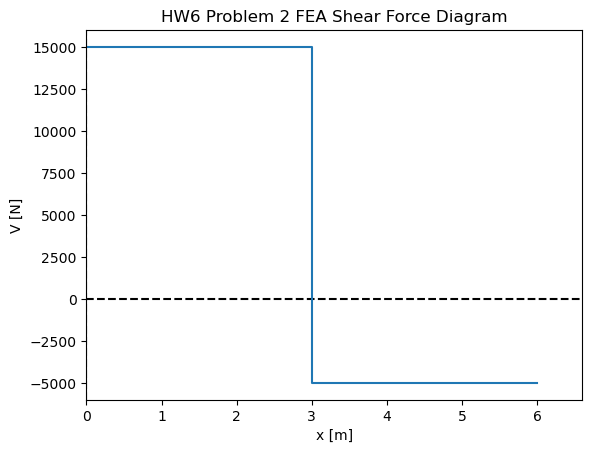

In [42]:
for i in range(len(elem_forces)):
    if check_even(i) == False:
        elem_forces[i] *= -1

shear_y_values = elem_forces
shear_y_values = [round(elem, 4) for elem in shear_y_values]
#shear_y_values.append(0)
print(f"y values = {shear_y_values}")

x_values = [0] * len(elem_forces)

for i in range(count_elems):
    print(i)
    x_values[2*i] += nodeCoordinates.value[i][0]
    x_values[(2*i) + 1] += nodeCoordinates.value[i+1][0]

#x_values.append(x_values[len(elem_forces) - 1])

print(f"x values = {x_values}")

shear_fig = plt.figure("Shear Figure")

plt.title(f"HW{homework_number} Problem {problem_number} FEA Shear Force Diagram")
plt.xlim(0, total_length * 1.1)
plt.axhline(0, color="black", linestyle = "--")
plt.axvline(0, color="black", linestyle = "--")
plt.ylabel(f"V [{FORCE_UNIT}]")
plt.xlabel(f"x [{LENGTHS_UNIT}]")
plt.plot(x_values, shear_y_values)

shear_fig.savefig(f"HW{homework_number} Problem {problem_number} Shear Figure")

plt.show()






y values = [-20000.0, 25000.0, 5000.0, -10000.0]
x values = [0, 3, 3, 6]


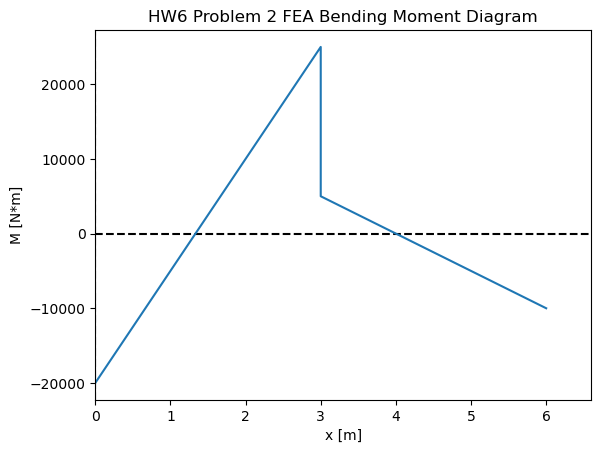

In [43]:
for i in range(len(elem_moments)):
    if check_even(i) == True:
        elem_moments[i] *= -1

moment_y_values = elem_moments
moment_y_values = [round(elem, 4) for elem in moment_y_values]
#moment_y_values.append(0)
print(f"y values = {moment_y_values}")

print(f"x values = {x_values}")

moment_fig = plt.figure("Moment Figure")

plt.title(f"HW{homework_number} Problem {problem_number} FEA Bending Moment Diagram")
plt.xlim(0, total_length * 1.1)
plt.axhline(0, color="black", linestyle = "--")
plt.axvline(0, color="black", linestyle = "--")
plt.ylabel(f"M [{FORCE_UNIT}*{LENGTHS_UNIT}]")
plt.xlabel(f"x [{LENGTHS_UNIT}]")
plt.plot(x_values, moment_y_values)

moment_fig.savefig(f"HW{homework_number} Problem {problem_number} Moment Figure")

plt.show()





0.0 3.0
3.0 6.0


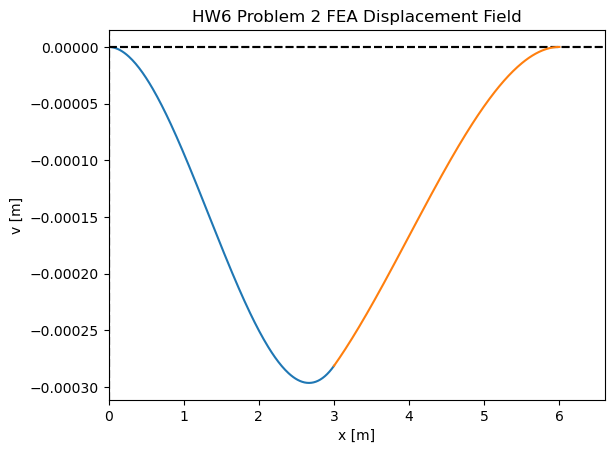

In [44]:
displacement_fig = plt.figure("Displacement Field")

for i in range(count_elems):
    disp_x_values = np.linspace(nodeCoordinates.value[i][0], nodeCoordinates.value[i+1][0], 200)
    print(disp_x_values[0], disp_x_values[199])
    
    def y(x): 
        return (
            create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,0] * final_u_phi[2 * i]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,1] * final_u_phi[(2 * i) + 1]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,2] * final_u_phi[(2 * i) + 2]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,3] * final_u_phi[(2 * i) + 3]
        )   
    
    disp_y_values = list(map(y, disp_x_values))

    #plot labels
    plt.title(f"HW{homework_number} Problem {problem_number} FEA Displacement Field")
    plt.xlim(0, total_length * 1.1)
    plt.axhline(0, color="black", linestyle = "--")
    plt.axvline(0, color="black", linestyle = "--")
    plt.ylabel(f"v [{LENGTHS_UNIT}]")
    plt.xlabel(f"x [{LENGTHS_UNIT}]")

    plt.plot(disp_x_values, disp_y_values)

displacement_fig.savefig(f"HW{homework_number} Problem {problem_number} Displacement Figure")
    
plt.show()
